In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from data_utils import SegItemListCustom, ImageListVertical
from data import data_dirs as data_env, get_label_with_context

from model import (
    UnetR34, get_resnet34,
    accuracy_segmentation, tensorboard_cb, 
)

from result_visualization import show_results

from fastai.vision import (
    Learner,
    open_image, open_mask,
    ImageList,
    get_transforms, imagenet_stats,
    ResizeMethod, DatasetType,
    plt,   # matplotlib.pyplot
    nn,    # torch.nn
    optim  # torch.optim
)
from fastai.callbacks.mem import PeakMemMetric

import warnings
warnings.filterwarnings("ignore")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

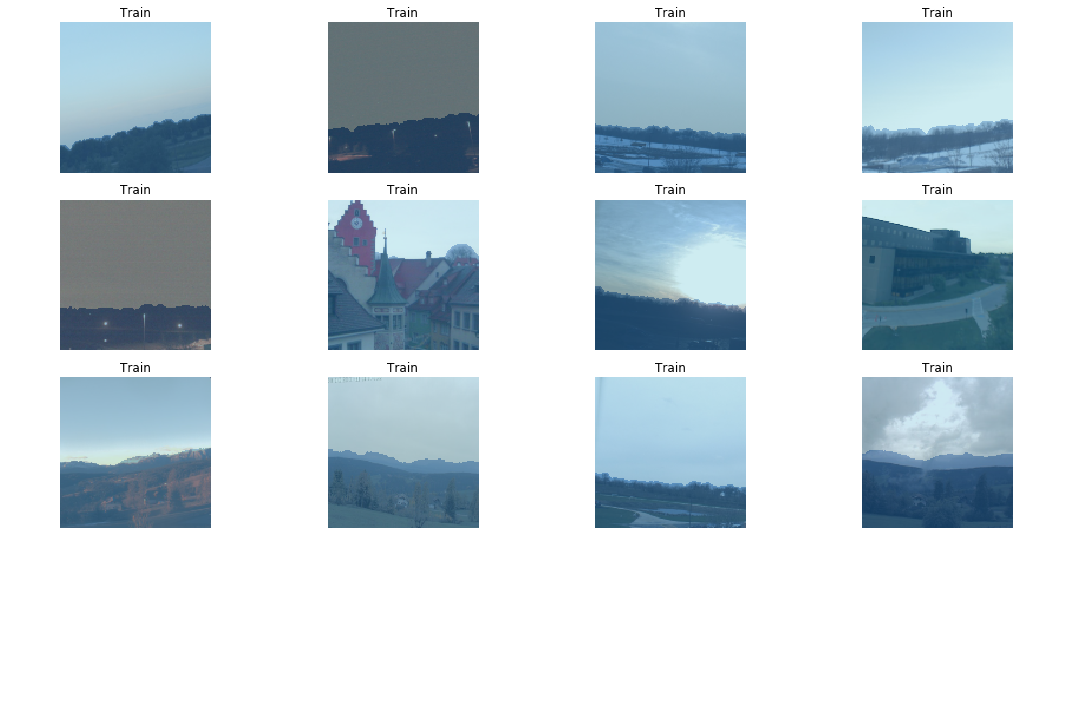

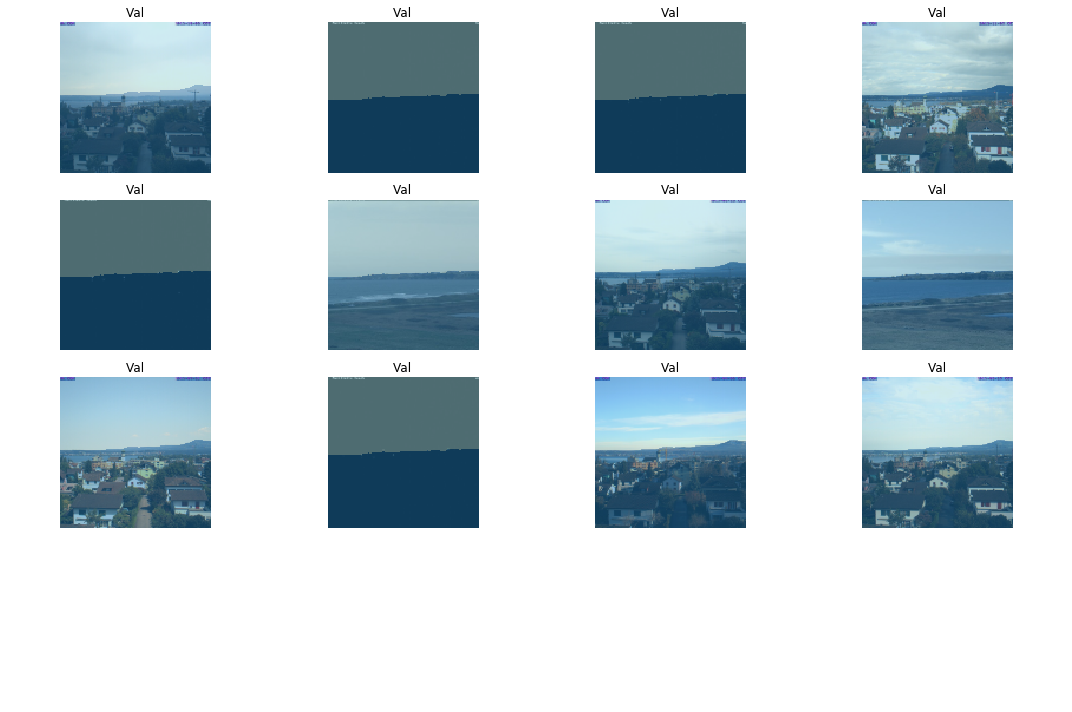

In [2]:
sizes = 128

src = (
    SegItemListCustom
    .from_folder(data_env.get_subdir("root"))
    .split_by_folder("train", "val")
    .label_from_func(get_label_with_context,
                     classes=["Sky", "Other"])
)
train_data = (
    src
    .transform(tfms=get_transforms()
                  , size=sizes, tfm_y=True)
    .databunch(bs=12)
    .normalize(imagenet_stats)
)
classes = train_data.c

train_data.show_batch(figsize=(15,10), title="Train")
train_data.show_batch(figsize=(15,10), title="Val", ds_type=DatasetType.Valid)

In [5]:
model = UnetR34(get_resnet34(), classes_num=classes)

learner = Learner(train_data, model)
learner.opt_fn = optim.Adam
learner.loss_fn = nn.BCEWithLogitsLoss()
learner.metrics = [accuracy_segmentation]

learner.freeze_to(1)

epoch,train_loss,valid_loss,accuracy_segmentation,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-01
Min loss divided by 10: 3.31E-01


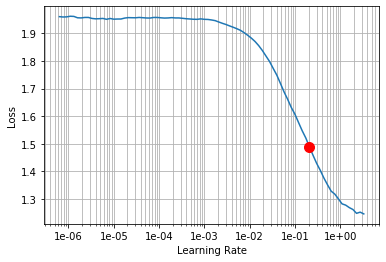

In [6]:
learner.lr_find()
learner.recorder.plot(suggestion=True, show_grid=True)

In [10]:
tb_callback = tensorboard_cb("/home/dmitri/Documents/tensorboard_logs", log_name="unet34_ocp_upsmplT_s128_mlr5e1")

epoch,train_loss,valid_loss,accuracy_segmentation,time
0,0.092488,0.196891,0.924080,01:14
1,0.114570,0.174244,0.946728,01:14
2,0.113286,0.143838,0.950339,01:14
3,0.167860,0.336388,0.934684,01:14
4,0.146333,0.459116,0.886027,01:14
5,0.184555,0.252487,0.936000,01:14
6,0.192216,0.214970,0.941072,01:15
7,0.154225,0.375927,0.897674,01:14
8,0.173276,0.194944,0.950747,01:14
9,0.148587,0.134054,0.953743,01:14


Cannot insert a Tensor that requires grad as a constant. Consider making it a parameter or input, or detaching the gradient
Tensor:
(1,1,.,.) = 
  0.4755  0.0000  0.0000  0.0000  0.0000  0.0000  0.1601  0.6125
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0095  0.1264
  0.0000  0.0000  0.1577  0.0442  0.0000  0.0000  0.0000  0.0190
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

(2,1,.,.) = 
  0.2755  0.1371  0.0000  0.0000  0.0000  0.0448  0.0781  0.0948
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



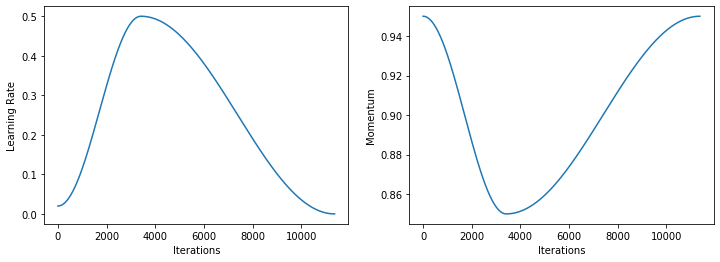

In [11]:
learner.fit_one_cycle(18, max_lr=5e-01, callbacks=[tb_callback(learner)])
learner.recorder.plot_lr(show_moms=True)

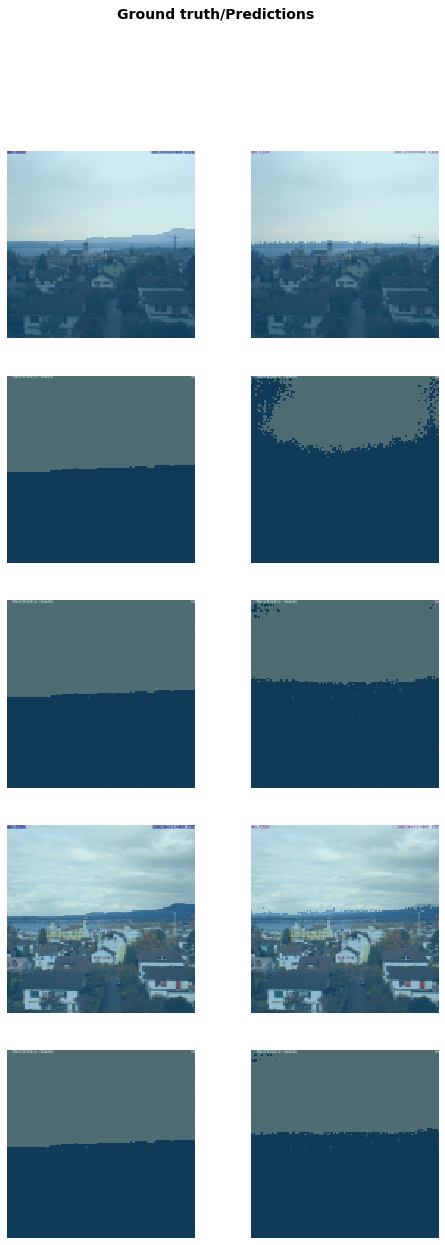

In [13]:
learner.show_results()

In [18]:

model.close()